# PP 2 Report: Analysis of the Geographical Features of the Scottish Road Network

Group 3: <br>
- Roel Beumers, s2113218
- Tom Gvero, s1688205
- Maciej Zielinski, s1657207
- Nina Fischer, s1635493

#### Introduction
The British Department of Transport monitors road traffic by, for example, sending people out to count the number of vehicles passing counting points on certain roads. 
Using the DfT's dataset which contains counting points information allows to analyse some interesting patterns of British traffic and the UK's road network.

This project focuses mostly on the analysis of geographical features of the Scottish Road Network and its usage. 
We begin by looking at the different sections of the Scottish Trunk Network to find out which section has the most traffic, and which mode of transportation is the most prominent. Linked to this, we next find the busiest roads in Scotland and their location. Focusing on the M8 allows to analyse traffic during the day for this particular road. After this, we explore the question whether the longest roads coincide with the busiest roads and whether the longest roads have the most counting points. Finally, we look at which local authority manages the most roads before concluding with a brief summary of our observations. 

#### Set up
This report requires the following packages. Most of those packages do not require a seperate installation. 
However, geopandas requires seperate installation. It also requires the package descartes which can also be installed via the terminal: `conda install descartes`. 
In case the reader is unable to install these packages, we ensured that the reader can still run the report without geopandas by simply not running the code boxes that use geopandas. 

In [1]:
# set up
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, importlib
import zipfile

In [2]:
import geopandas as gpd
from shapely.geometry import Point
pd.options.mode.chained_assignment = None # default = 'warn'

In [3]:
# import data 
data = pd.read_csv('dft_rawcount_region_id_3.csv', 
                   sep=",", 
                   dtype={'count_point_id': int,
                          'direction_of_travel': str,
                          'year': int,
                          'count_date': str,
                          'hour': int,
                          'region_id': int,
                          'region_name': str,
                          'local_authority_id': int,
                          'local_authority_name': str,
                          'road_name': str,
                          'road_type': str,
                          'start_junction_road_name': str,
                          'end_junction_road_name': str,
                          'easting': int,
                          'northing': int,
                          'latitude': float,
                          'longitude': float,
                          'link_length_km': float,
                          'link_length_miles': float,
                          'pedal_cycles': int,
                          'two_wheeled_motor_vehicles': int,
                          'cars_and_taxis': int,
                          'buses_and_coaches': int,
                          'lgvs': int,
                          'hgvs_2_rigid_axle': int,
                          'hgvs_3_rigid_axle': int,
                          'hgvs_3_or_4_articulated_axle': int,
                          'hgvs_4_or_more_rigid_axle': int,
                          'hgvs_5_articulated_axle': int,
                          'hgvs_6_articulated_axle': int,
                          'all_hgvs': int,
                          'all_motor_vehicles': int})

rows = len(data)
col = len(data.columns)


The shapefiles for the maps drawn in this report come from the OS Open Roads dataset (see https://www.ordnancesurvey.co.uk/business-government/products/open-map-roads) and from the Office for National Statistics for the data on local authority boundaries (see https://geoportal.statistics.gov.uk/datasets/local-authority-districts-december-2017-boundaries-gb-buc/data). They are stored compressed in the data folder. 

Unfortunately some of us seem to have problems unzipping the files after downloading them from git. Our theory is that pushing the compressed zip folders to git compromises them, and changes their type, so that `is.zipfile(zipfile_name)` is False for some of us. Therefore we ask the reader to run this code only after looking at the whole project first.


In [4]:
# unzip files - might not work for everyone
zipfile_path_roads = "data/oproad_essh_gb.zip"
with zipfile.ZipFile(zipfile_path_roads, 'r') as zip_ref:
    zip_ref.extractall("data/data_roads")

zipfile_path_LAD = "data/LAD.zip"
with zipfile.ZipFile(zipfile_path_LAD, 'r') as zip_ref:
    zip_ref.extractall("data/data_LAD")

In [5]:
# import data for maps-only works if you were able to unzip the files - this takes a while
full_data = gpd.read_file("data/data_LAD/LAD/Local_Authority_Districts__December_2017__Boundaries_in_Great_Britain.shp")

# read in all shapefiles(.shp) that cover scotland's roads (those shapefiles begin with 'N')
path = os.getcwd() +'/data/data_roads/oproad_essh_gb/data/'
fs = [f for f in os.listdir(path) if f.endswith('RoadLink.shp') and f[0] == 'N']
# read in files and merge them together to one big shape file
base = gpd.read_file(path + fs[0])
for file in fs:
    base = base.append(gpd.read_file(path + file))


In [6]:
# filter for Scotland's local authorities in Locol Authorities File (LAD)
scotland = 'S'
# create boolean vector that stores true false whether lad17cd begins with S
is_scotland = full_data["lad17cd"].str.startswith(scotland) 
scotland_gpd_df = full_data[is_scotland]

# Which trunk road network has the most traffic?

A Trunk Road is a major connecting road in the UK. The map below shows the trunk roads within Scotland and the ones connecting Scotland to England.

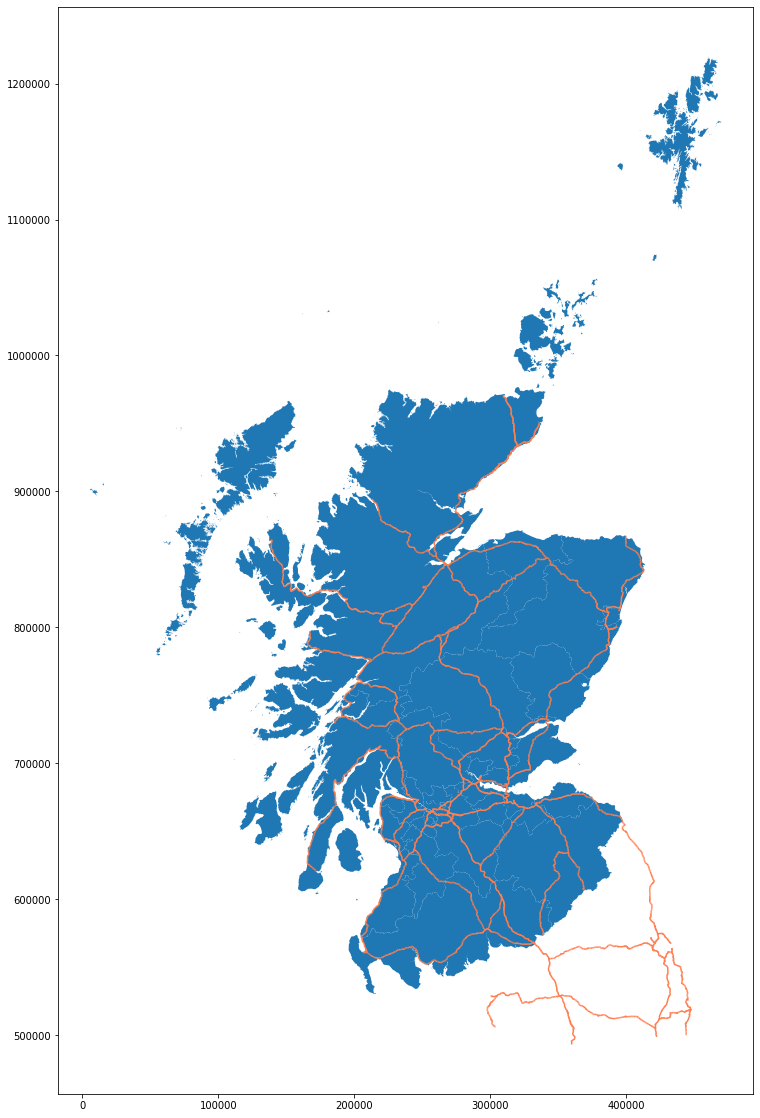

In [7]:
trunkRoad = base[base['trunkRoad'] == 'true']
                 
fig, ax = plt.subplots(figsize=(25, 20))
ax.set_aspect('equal')

scotland_gpd_df.plot(ax=ax,)
trunkRoad.plot(ax=ax, markersize=0.001, color='Coral')

Every year the national transport agency for Scotland releases Scottish Transport Statistics, containing useful information about traffic on the Scottish road network (https://www.transport.gov.scot/publication/scottish-transport-statistics-no-35-2016-edition/sct01171871341-08/). As can be seen in figure 5.1, the major roads in the Scottish road network are divided into smaller trunk road networks. These different networks are managed by different sections of BEAR Scotland. We decided to investigate through which of these networks the most traffic passes and whether the distribution of different types of traffic differs between the regions. 

In [8]:
# the data in df must be filtered for all the major roads that are counted in 2019 and the duplicates in the data deleted
roadlist = data.loc[(data['road_type']=='Major') & (data['year'] == 2019)]["road_name"].unique().tolist()

In [9]:
# create a dictionary and sum up all of the values in the given columns for 2019 for every road in the roadlist
dic={}
for a in roadlist:
    
    traffic = data.loc[(data['road_name'] == a) & (data['year'] == 2019)] 
    traffic = traffic.loc[:, ['buses_and_coaches', 'two_wheeled_motor_vehicles', 'cars_and_taxis', 'lgvs', 'all_hgvs', 'all_motor_vehicles']].sum(axis=0)
    
    dic[a] = traffic

In [10]:
#change the dictionary into a pandas dataframe
pd.DataFrame.from_dict(dic)
#transpose the dataframe for readability and ease of calculation
transpose = pd.DataFrame.from_dict(dic).T
transpose

,buses_and_coaches,two_wheeled_motor_vehicles,cars_and_taxis,lgvs,all_hgvs,all_motor_vehicles
A905,87,68,16431,2883,1196,20665
A966,10,1,222,36,0,269
A947,111,68,11353,2175,733,14440
A72,91,37,8238,1530,223,10119
A725,207,131,48039,12177,6359,66913
...,...,...,...,...,...,...
A967,24,6,667,181,12,890
A897,3,2,207,58,28,298
A82,95,114,2423,719,187,3538
A97,10,16,1070,296,77,1469


BEAR Scotland provides which trunks roads belong to which network on their website (https://www.bearscot.com/nw/). For every given road we checked whether the road appeared in the data and added it to the list below if it did indeed appear.

In [11]:
# for every road in the region the roads that appear in the data are put into a list
North_West = ['A9', 'A82', 'A83', 'A84', 'A85', 'A87', 'A830', 'A835']
North_East = ['A90', 'A92', 'A95','A96', 'A9']
South_East = ['M8', 'A8', 'A90', 'A823', 'M876', 'A1', 'A720', 'A702', 'A7', 'A977']
South_West = ['A82', 'M8', 'A898', 'M74', 'A725', 'A726', 'A8', 'A76', 'A751', 'A77', 'M77']

In [12]:
#by using the list for the region, a dictionary can be created which sums up the data in the columns for the roads in the right list
NW_dict = {}
sum_buses = 0
sum_two = 0
sum_cars = 0
sum_lg = 0
sum_allh = 0
sum_motor = 0
for road in North_West:
    sum_buses  += dic[road][0]
    sum_two += dic[road][1]
    sum_cars  += dic[road][2]
    sum_lg  += dic[road][3]
    sum_allh  += dic[road][4]
    sum_motor  += dic[road][5]

NW_dict['buses_and_coaches'] = sum_buses
NW_dict['two_wheeled_motor_vehicles'] = sum_two
NW_dict['cars_and_taxis'] = sum_cars
NW_dict['lgvs'] = sum_lg
NW_dict['all_hgvs'] = sum_allh
NW_dict['all_motor_vehicles'] = sum_motor

In [13]:
NE_dict = {}
sum_buses = 0
sum_two = 0
sum_cars = 0
sum_lg = 0
sum_allh = 0
sum_motor = 0

for roads in North_East:
    sum_buses  += dic[roads][0]
    sum_two += dic[roads][1]
    sum_cars  += dic[roads][2]
    sum_lg  += dic[roads][3]
    sum_allh  += dic[roads][4]
    sum_motor  += dic[roads][5]
    
NE_dict['buses_and_coaches'] = sum_buses
NE_dict['two_wheeled_motor_vehicles'] = sum_two
NE_dict['cars_and_taxis'] = sum_cars
NE_dict['lgvs'] = sum_lg
NE_dict['all_hgvs'] = sum_allh
NE_dict['all_motor_vehicles'] = sum_motor

In [14]:
SE_dict3 = {}
sum_buses = 0
sum_two = 0
sum_cars = 0
sum_lg = 0
sum_allh = 0
sum_motor = 0
for road in South_East:
    sum_buses  += dic[road][0]
    sum_two += dic[road][1]
    sum_cars  += dic[road][2]
    sum_lg  += dic[road][3]
    sum_allh  += dic[road][4]
    sum_motor  += dic[road][5]

SE_dict3['buses_and_coaches'] = sum_buses
SE_dict3['two_wheeled_motor_vehicles'] = sum_two
SE_dict3['cars_and_taxis'] = sum_cars
SE_dict3['lgvs'] = sum_lg
SE_dict3['all_hgvs'] = sum_allh
SE_dict3['all_motor_vehicles'] = sum_motor


In [15]:
SW_dict = {}
sum_buses = 0
sum_two = 0
sum_cars = 0
sum_lg = 0
sum_allh = 0
sum_motor = 0
for road in South_West:
    sum_buses  += dic[road][0]
    sum_two += dic[road][1]
    sum_cars  += dic[road][2]
    sum_lg  += dic[road][3]
    sum_allh  += dic[road][4]
    sum_motor  += dic[road][5]

SW_dict['buses_and_coaches'] = sum_buses
SW_dict['two_wheeled_motor_vehicles'] = sum_two
SW_dict['cars_and_taxis'] = sum_cars
SW_dict['lgvs'] = sum_lg
SW_dict['all_hgvs'] = sum_allh
SW_dict['all_motor_vehicles'] = sum_motor

In [16]:
#the dictionaries are added together into a single list
ap = []
ap.append(NW_dict)
ap.append(NE_dict)
ap.append(SE_dict3)
ap.append(SW_dict)

In [17]:
# the list is transformed into a pandas dataframe
final = pd.DataFrame(ap)
# the key names are changed to the names of the regions
final = final.rename (index = {0 : 'North West', 1 : 'North East', 2 : 'South East', 3 : 'South West'})
final

,buses_and_coaches,two_wheeled_motor_vehicles,cars_and_taxis,lgvs,all_hgvs,all_motor_vehicles
North West,2149,1175,169046,39530,16388,228288
North East,3125,1607,373020,80657,34994,493403
South East,5209,2213,477083,103038,37247,624790
South West,4542,1734,394259,88682,31917,521134


The table above shows the amounts of traffic per region in 2019. 
To visualise the difference per region we made the bar chart below. As can be seen from the chart, South East is the region with the most traffic. South West and North East seem to have roughly the same amount of traffic. North West clearly has the lowest amount of total traffic. 


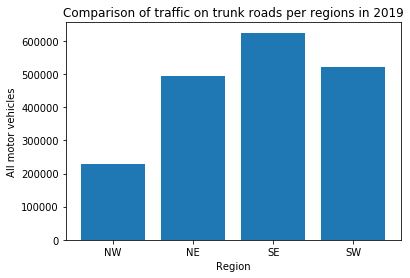

In [18]:
#to visualise the total traffic per region the total amount of motor vehicles per region are compared with a bar chart
total_2019 = {"NW": 228288, "NE": 493403, "SE": 624790, "SW": 521134}
keys = total_2019.keys()
values = total_2019.values()

plt.title("Comparison of traffic on trunk roads per regions in 2019")
plt.ylabel("All motor vehicles")
plt.xlabel("Region")
plt.bar(keys, values)
print('')

Another question we wanted to look into is the difference in distribution of traffic between the networks. The following pie charts visualise the proportion of traffic per category of traffic. As can be seen in the pie charts, the proportion per category of the total traffic seems to be identical between the regions. Cars and taxis make up roughly 75% of traffic, lgvs 17%, hgvs 7% and motor bikes and buses make up 1%. 

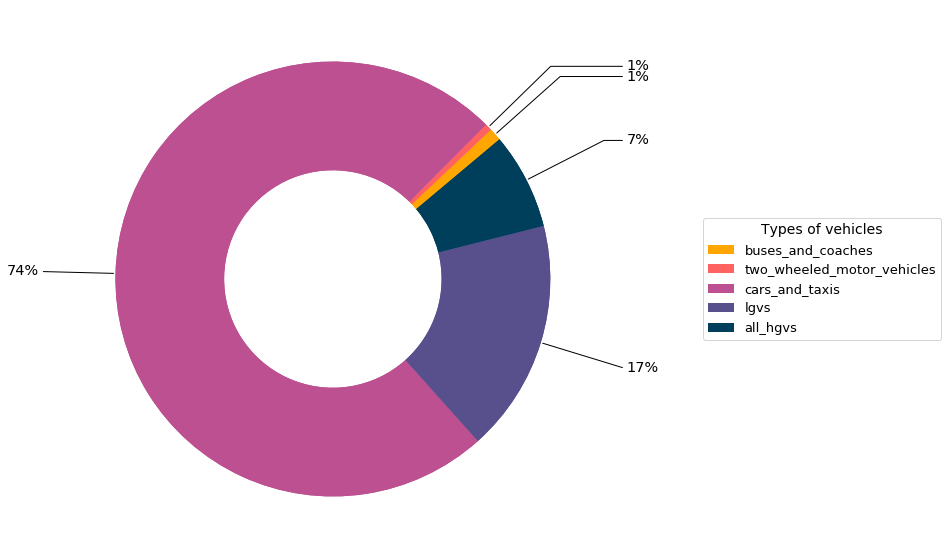

In [19]:
custom_five = ["#ffa600", "#ff6361", "#bc5090", "#58508d", "#003f5c"]
sns.set_palette(custom_five)

# the donut chart below was created partially using the code from:
# https://matplotlib.org/3.1.0/gallery/pie_and_polar_charts/pie_and_donut_labels.html
# Accessed on 05 Dec 2020.

# the follow pie charts visualise the distribution of types of vehicles per region
NW_type = ["buses_and_coaches", "two_wheeled_motor_vehicles", 'cars_and_taxis', 'lgvs', 'all_hgvs']
NW_values = [2149, 1175, 169046, 39530, 16388]
NW_summed = np.sum(NW_values)

fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(NW_values, wedgeprops=dict(width=0.5), startangle=40)
plt.pie(NW_values, labels=NW_type, labeldistance=None, textprops={'fontsize': 14}, 
        wedgeprops=dict(width=0.5), startangle=40)
plt.legend(loc="center",  bbox_to_anchor=(1.4, 0.5), title="Types of vehicles", prop={"size":13}, title_fontsize=14)

# add lines to the percentages
kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    plt.annotate("{:.0%}".format(NW_values[i]/NW_summed), xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw, fontsize=14.5)
plt.show()

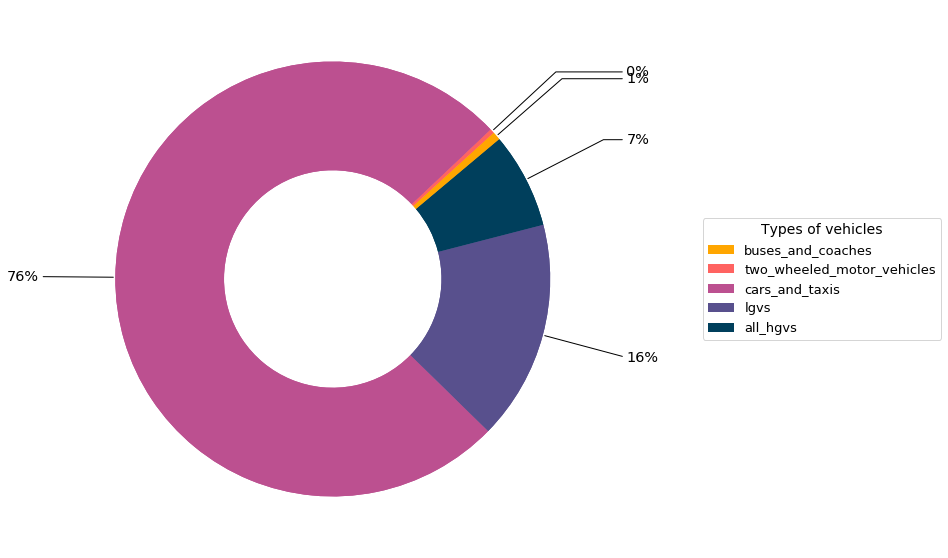

In [20]:
# the follow pie charts visualise the distribution of types of vehicles per region
NE_type = ["buses_and_coaches", "two_wheeled_motor_vehicles", 'cars_and_taxis', 'lgvs', 'all_hgvs']
NE_values = [3125, 1607, 373020, 80657, 34994]
NE_summed = np.sum(NE_values)

fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(NE_values, wedgeprops=dict(width=0.5), startangle=40)
plt.pie(NE_values, labels=NE_type, labeldistance=None, textprops={'fontsize': 14}, 
        wedgeprops=dict(width=0.5), startangle=40)
plt.legend(loc="center",  bbox_to_anchor=(1.4, 0.5), title="Types of vehicles", prop={"size":13}, title_fontsize=14)

# add lines to the percentages
kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    plt.annotate("{:.0%}".format(NE_values[i]/NE_summed), xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw, fontsize=14.5)
plt.show()

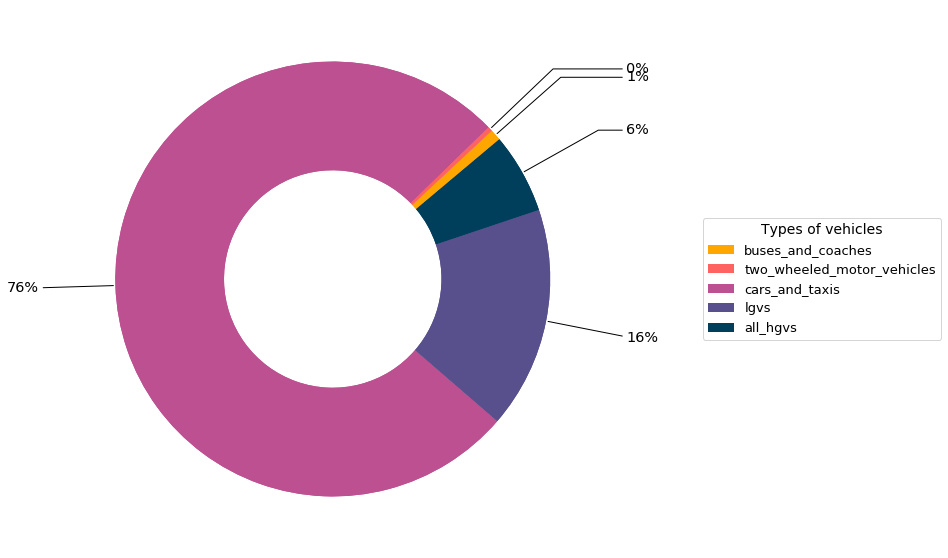

In [21]:
# the follow pie charts visualise the distribution of types of vehicles per region
SE_type = ["buses_and_coaches", "two_wheeled_motor_vehicles", 'cars_and_taxis', 'lgvs', 'all_hgvs']
SE_values = [5209, 2213, 477083, 103038, 37247]
SE_summed = np.sum(SE_values)

fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(SE_values, wedgeprops=dict(width=0.5), startangle=40)
plt.pie(SE_values, labels=SE_type, labeldistance=None, textprops={'fontsize': 14}, 
        wedgeprops=dict(width=0.5), startangle=40)
plt.legend(loc="center",  bbox_to_anchor=(1.4, 0.5), title="Types of vehicles", prop={"size":13}, title_fontsize=14)

# add lines to the percentages
kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    plt.annotate("{:.0%}".format(SE_values[i]/SE_summed), xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw, fontsize=14.5)
plt.show()

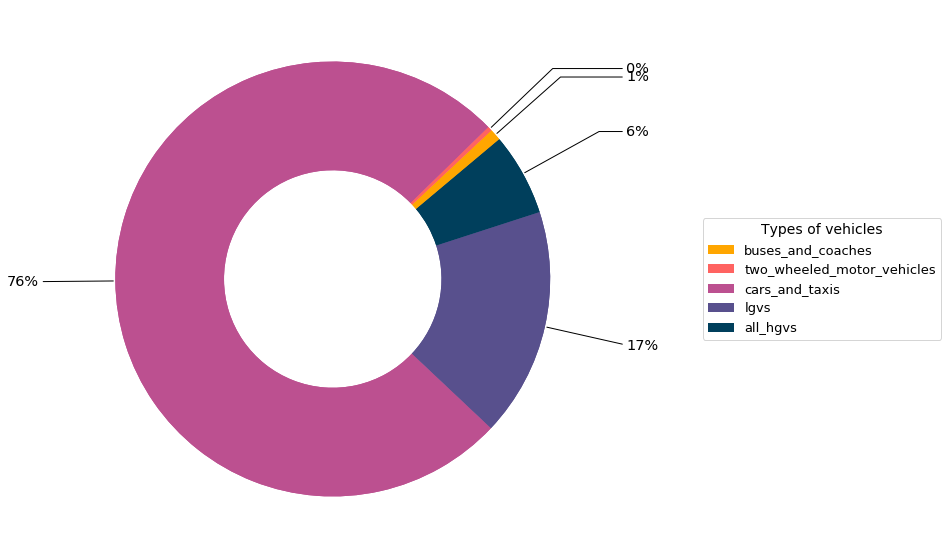

In [22]:
# the follow pie charts visualise the distribution of types of vehicles per region
SW_type = ["buses_and_coaches", "two_wheeled_motor_vehicles", 'cars_and_taxis', 'lgvs', 'all_hgvs']
SW_values = [4542, 1734, 394259, 88682, 31917]
SW_summed = np.sum(SW_values)

fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(SW_values, wedgeprops=dict(width=0.5), startangle=40)
plt.pie(SW_values, labels=SW_type, labeldistance=None, textprops={'fontsize': 14}, 
        wedgeprops=dict(width=0.5), startangle=40)
plt.legend(loc="center",  bbox_to_anchor=(1.4, 0.5), title="Types of vehicles", prop={"size":13}, title_fontsize=14)

# add lines to the percentages
kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    plt.annotate("{:.0%}".format(SW_values[i]/SW_summed), xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw, fontsize=14.5)
plt.show()



There's no significant difference in the distribution of the different vehicle category per road. However, there is a significant different in the total amount of traffic per region. In the the next section we will look at which roads are the busiest in terms of traffic and where they are located. 

# Which is the busiest road in Scotland?

In order to quantify which is the busiest road in Scotland, we will look at which road has the highest average number of vehicles counted per count, as the frequency of these counts differs massively from road to road. Also, we will choose to ignore roads named "U" or "C" as these refer to unspecified minor roads which we are unable to tell the difference between - (it is unlikely that any of these will be the busiest road anyway!). 

In [23]:
#remove data for U and C road - not interested in that here
df_noU = data[data.road_name != "U"]
df_noUC = df_noU[df_noU.road_name != "C"]
#Only keeps columns of the road name and total count
df_filter = df_noUC[["road_name","all_motor_vehicles"]]
#Sums the counts by road name - gives total number of vehicles counted on each road
count_sums = df_filter.groupby(["road_name"]).sum()
total_vehicles = count_sums[sorted(count_sums)]

df_filter2 = df_noUC[["road_name","count_date"]]
#data frame containing number of counts per road per date
counts_per_date = df_filter2.groupby(["road_name","count_date"]).size()
#sum the counts over all dates to get total counts per road
counts_per_road = counts_per_date.groupby(["road_name"]).sum()
#divide total counted vehicles by number of counts to get average vehicles per count
avg_per_count = total_vehicles["all_motor_vehicles"]/counts_per_road
#Take the top 5
top5overall = avg_per_count.sort_values(ascending=False).head()

#subset of original data frame including counts for all vehicle types
vehicle_type = df_noUC[["road_name","pedal_cycles","two_wheeled_motor_vehicles","cars_and_taxis","buses_and_coaches",
        "lgvs","all_hgvs","all_motor_vehicles"]]
#calculate total count per vehicle type for each road
total_count_vt = vehicle_type.groupby(["road_name"]).sum()
#divides by total number of counts to get average per count
avg_per_count_vt = total_count_vt.div(counts_per_road,axis=0)

#list of vehicle types for looping purposes
types = ["pedal_cycles","two_wheeled_motor_vehicles","cars_and_taxis","buses_and_coaches",
        "lgvs","all_hgvs","all_motor_vehicles"]
#initialise data frame to store road names
storage = pd.DataFrame()
#loop through vehicle types storing 5 most common roads in storage data frame
for i in types:
    top5roads = avg_per_count_vt[i].sort_values(ascending=False).head().to_frame()
    index = top5roads.index
    road_list = list(index)
    storage[i] = road_list
    
#change the index column from 0-4 to 1-5 to indicate top 5 busiest order
storage["index"] = [1,2,3,4,5]
storage.set_index("index")

,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,lgvs,all_hgvs,all_motor_vehicles
index,,,,,,,
1,A900,A720,M8,A900,M8,M74,M8
2,A700,M8,A720,A8014,M73,M73,A720
3,A9000,A898,M73,A877,A720,M8,M73
4,B853,A74M,A739,A741,A80,A74M,A80
5,B900,A90,A80,A9013,A725,A80,M80


The table above shows the top 5 roads for each vehicle class, as well as for all vehicles, with regards to the highest average number of vehicles counted per count over the whole of the 20 year period for which we have data. What we can see is that generally, the same sorts of roads seems to appear across the table. The exceptions to this are pedal cycles and buses and coaches, which seem overall to appear on less major roads than the other vehicle types. This makes some sense as it would be extremely dangerous to cycle down the M8!

One issue with this data is that the busyness of certain roads may be affected by the time of day on which counts are taken. For example, if road A has most of its counts taken at rush hour, and another road B has most of its counts taken during the middle of the day when everyone is at work, then road A will clearly appear busier than road B, even if this isn't truly the case. Let's have a look at how the count times are distributed for each of these busiest 5 roads.



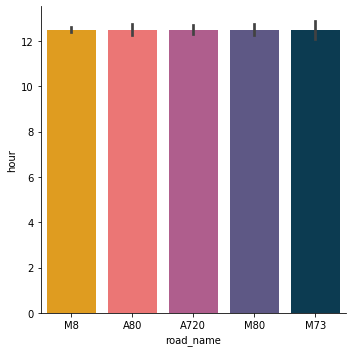

In [24]:
times = df_noUC[["road_name","hour"]]

#top 5 roads we are interested in
roads = ["M8","A720","M73","A80","M80"]
#filters the data into just the top 5 roads
top5times = times[times.road_name.isin(roads)]
#takes the mean count hour for each road
top5times.groupby("road_name").mean()

sns.catplot(data = top5times,
           kind = "bar",
           x="road_name",
           y="hour")

What we see from this bar chart is that the times of the counts for each road are distributed almost identically, so we can conclude that the table we have produced above is a fair representation of how busy each of these roads is relative to eachother. We also carried out this same comparison for every single road in the data set and the average time of counts was distributed almostly identically for every single road, although the graph produced was too untidy to present here. 

We will now have a look at where these busiest roads lie geographically.

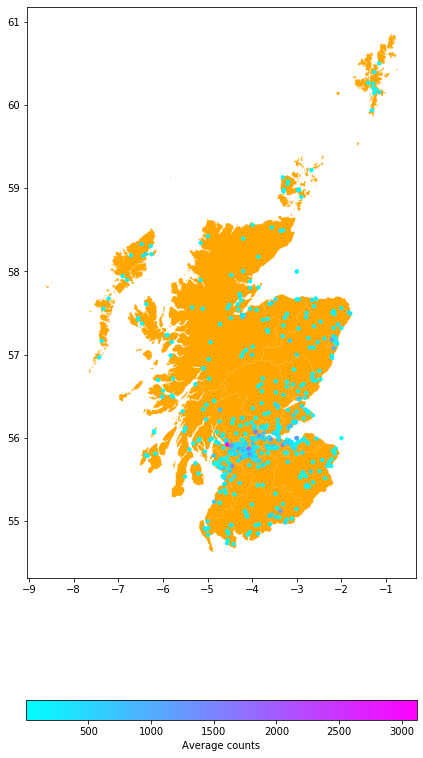

In [25]:
name_groups = df_noUC.groupby("road_name")
#initialise storage data frame
info = pd.DataFrame()
#loop through each piece of info we require for our plot
for i in ["road_name","latitude","longitude"]:
    #takes the first instance of each variable
    info[i] = name_groups[i].first()
#adds data for the average vehicles per count    
info["avg_count"] = avg_per_count

info['coordinates'] = info[['longitude', 'latitude']].values.tolist()
info['coordinates'] = info['coordinates'].apply(Point)
info = gpd.GeoDataFrame(info, geometry='coordinates', crs = 4326)

fig, ax = plt.subplots(1, figsize=(7,15))
scotland_gpd_df_crs = scotland_gpd_df.to_crs('epsg:4326')
scotland_base = scotland_gpd_df_crs.plot(ax=ax)
info.plot(column='avg_count', ax=scotland_base, legend=True, 
          legend_kwds={'label': "Average counts", 'orientation': "horizontal"}, marker='o', markersize=11, cmap="cool")

The scatter plot above shows the location of a count point for each individual road - we haven't plotted every single one because there are far too many and the graph would quickly become unreadable, but this gives a rough idea of where these roads lie. The points become more purple the busier the road has been over the last 20 years - i.e. the highest average number of vehicles counted per count. What we see is that the busiest roads are all along the corridor between Edinburgh and Glasgow, which is an interesting point to note. This makes logical sense as Scotland's "central belt" contains around 70% of the total population. Included in this region is the M8, which appears at the top of the busiest roads overall and in almost all of the individual vehicle type top 5's as well (referring back to our table of the top 5 busiest roads). 

We will now explore the M8 further. The M8 connects Glasgow and Edinburgh and we anticipate that there will be people who commute from one city to another along this road. The question is: which commute is more common? To investigate this we will split our data up into morning and afternoon rush hours. The time windows we have chosen for this are 7-10am for the morning and 4-7pm for the afternoon. This should give us a rough idea of which direction is the more common commute.






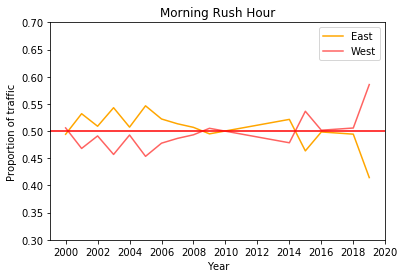

In [26]:
#initialise storage data frame
proportions = pd.DataFrame()
#loop through each year of data
for i in range(1,21):
    #specify the year based on the loop we are in    
    thisyear = 2000+i-1    
    #extracts just the data for the M8
    m8_data = data[data.road_name == "M8"]
    #filters further to look at the current year
    m8_data = m8_data[m8_data.year == thisyear]

    #split the data into east and west
    m8_east = m8_data[m8_data.direction_of_travel == "E"]
    m8_west = m8_data[m8_data.direction_of_travel == "W"]
    
    #filters east data into the concerned time windows for each rush hour
    m8_east_morn = m8_east[m8_east.hour<=10]
    m8_east_aft = m8_east[m8_east.hour<=19]
    m8_east_aft = m8_east_aft[m8_east_aft.hour>=16]

    #takes sum of all counts and number of counts and calculate average count
    num_east_morn_counts = m8_east_morn[["all_motor_vehicles"]].count()
    num_east_morn_counted = m8_east_morn[["all_motor_vehicles"]].sum()
    total_morn_east = num_east_morn_counted/num_east_morn_counts
    
    #same as above but for afternoon
    num_east_aft_counts = m8_east_aft[["all_motor_vehicles"]].count()
    num_east_aft_counted = m8_east_aft[["all_motor_vehicles"]].sum()
    total_aft_east = num_east_aft_counted/num_east_aft_counts
    
    #same as we did for east but now for west
    m8_west_morn = m8_west[m8_west.hour<=10]
    m8_west_aft = m8_west[m8_west.hour<=19]
    m8_west_aft = m8_west_aft[m8_west_aft.hour>=16]

    num_west_morn_counts = m8_west_morn[["all_motor_vehicles"]].count()
    num_west_morn_counted = m8_west_morn[["all_motor_vehicles"]].sum()
    total_morn_west = num_west_morn_counted/num_west_morn_counts

    num_west_aft_counts = m8_west_aft[["all_motor_vehicles"]].count()
    num_west_aft_counted = m8_west_aft[["all_motor_vehicles"]].sum()
    total_aft_west = num_west_aft_counted/num_west_aft_counts
    
    #calculate proportion of trips in each rush hour which went in either direction
    prop_morn_east = total_morn_east/(total_morn_east+total_morn_west)
    prop_morn_west = 1 - prop_morn_east

    prop_aft_east = total_aft_east/(total_aft_east+total_aft_west)
    prop_aft_west = 1 - prop_aft_east
    
    #store these values in our data frame under year column
    proportions[thisyear] = [prop_morn_east.values,prop_morn_west.values,prop_aft_east.values,prop_aft_west.values]

    
proportions = proportions.astype(float)
data_range = np.arange(2000,2020)
mask1 = np.isfinite(proportions.iloc[0])
mask2 = np.isfinite(proportions.iloc[1])
plt.plot(data_range[mask1],proportions.iloc[0][mask1],label="East")
plt.plot(data_range[mask2],proportions.iloc[1][mask2],label="West")
plt.axhline(y=0.5, color='r', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Proportion of traffic")
plt.ylim((0.3,0.7))
plt.legend()
plt.title("Morning Rush Hour")
plt.xticks(np.arange(2000,2022,2))
plt.show()

The above graph shows that although there is a huge amount of traffic going in either direction, the early 2000's saw a slightly higher proportion of cars travelling east, implying a Glasgow to Edinburgh commute. This has fluctuated throughout the years but as of 2019, there now appears to be far more people doing the opposite commute: Edinburgh to Glasgow. We now need to see if this is reciprocated by the afternoon rush hours.

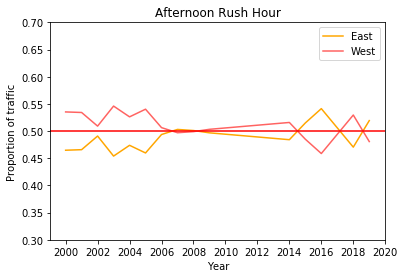

In [27]:
mask3 = np.isfinite(proportions.iloc[2])
mask4 = np.isfinite(proportions.iloc[3])
plt.plot(data_range[mask3],proportions.iloc[2][mask3],label="East")
plt.plot(data_range[mask4],proportions.iloc[3][mask4],label="West")
plt.axhline(y=0.5, color='r', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Proportion of traffic")
plt.ylim((0.3,0.7))
plt.legend()
plt.title("Afternoon Rush Hour")
plt.xticks(np.arange(2000,2022,2))
plt.show()

What we see from the afternoon graph is roughly the oppposite of the morning graph, which is good because it tells us that the excess of people travelling in one direction in the morning are returning in the afternoon, hinting that the nature of the trips is a commute. Of course, this is a slight generalisation as we cannot be certain of the nature of these trips, but it does give us a good indication. 

Now that we have explored Scotland's busiest roads, it would be interesting to see how this coincides with the length of the road.

# Finding the longest road in Scotland 

,road_name,length
189,A9,445.2
190,A90,277.1
121,A82,274.0
137,A836,194.3
133,A832,184.2
224,A93,176.2
163,A87,160.8
248,A96,159.7
130,A83,158.7
69,A75,156.3


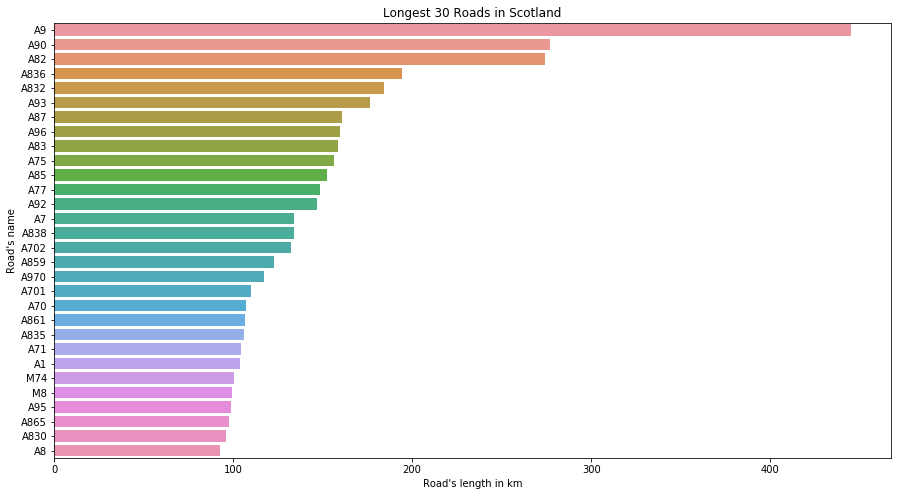

In [28]:
data_clear = data.drop_duplicates('count_point_id')
longest_roads = data_clear.groupby(['road_name']).link_length_km.sum()
longest_roads = longest_roads.reset_index(name='length')
longest_roads = longest_roads.sort_values('length', ascending=False).head(30)
display(longest_roads.head(10))

plt.figure(figsize=(15,8))
sns.barplot(x = longest_roads.length, y = longest_roads.road_name)
plt.xlabel("Road's length in km")
plt.ylabel("Road's name")
plt.title('Longest 30 Roads in Scotland')
plt.show()


The plot above shows that the A9 is by far the longest road in Scotland. Geographically this is very plausible since it connects the Central Belt to Thurso, one of the most northern towns on mainland Scotland, which is demonstrated in the map below. 

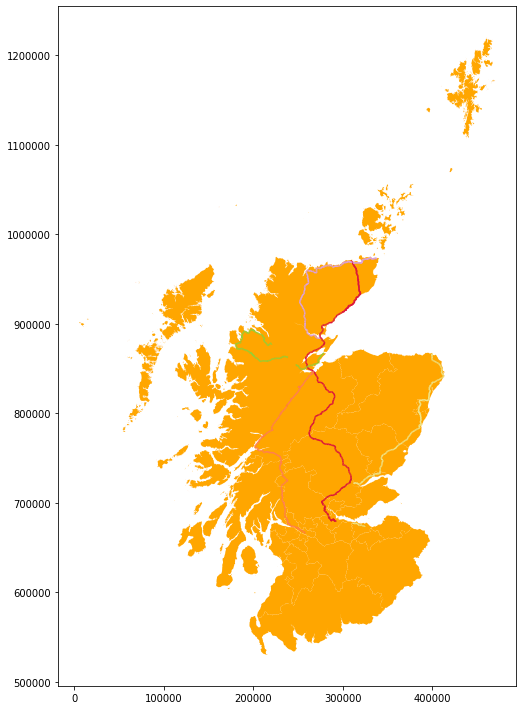

In [29]:
## plot top 5 longest roads
a9 = base[base['roadNumber'] == 'A9']

longest_list = ['A9', 'A90', 'A82', 'A836', 'A832']

a90 = base[base['roadNumber'] == 'A90']
a82 = base[base['roadNumber'] == 'A82']
a836 = base[base['roadNumber'] == 'A836']
a832 = base[base['roadNumber'] == 'A832']


fig, ax = plt.subplots(figsize=(17.5, 12.5))
ax.set_aspect('equal')

scotland_gpd_df.plot(ax=ax)
a9.plot(ax=ax, markersize=0.001, color='Crimson')
a90.plot(ax=ax, markersize=0.001, color='Khaki')
a82.plot(ax=ax, markersize=0.001, color='Coral')
a836.plot(ax=ax, markersize=0.001, color='Plum')
a832.plot(ax=ax, markersize=0.001, color='YellowGreen')


When looking at the map for showing the longest roads in Scotland, we see that 4 out of the 5 longest roads 
connect the North with the South.
Since the A9 (plotted here in Crimson red) is the longest road, we analyse next if the A9 also has the most number of different counting points.
# Which road has the most number of different counting points along it?

,road_name,counts
92,A8,76
189,A9,66
190,A90,59
82,A77,49
488,M8,48
121,A82,38
248,A96,36
215,A92,35
21,A7,35
104,A803,30


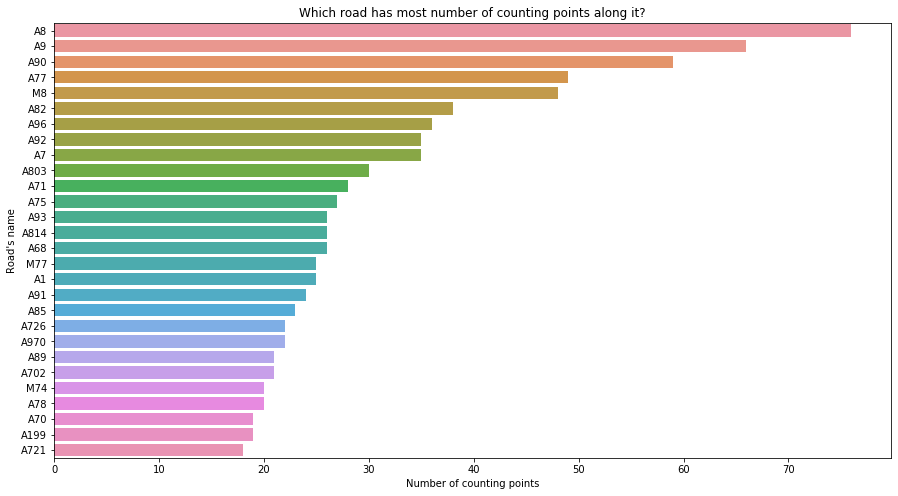

In [30]:
data_clear = data.drop_duplicates('count_point_id')
most_counting_points = data_clear.groupby(['count_point_id']).road_name.value_counts()
most_counting_points = most_counting_points.reset_index(name='counts')
most_counting_points = most_counting_points.groupby(['road_name']).counts.sum()
most_counting_points = most_counting_points.reset_index(name='counts')
most_counting_points = most_counting_points.sort_values('counts', ascending=False).head(30)
is_u = most_counting_points['road_name']=='U'
most_counting_points = most_counting_points[-is_u]
is_c = most_counting_points['road_name']=='C'
most_counting_points = most_counting_points[-is_c]
display(most_counting_points.head(10))

plt.figure(figsize=(15,8))
sns.barplot(x = most_counting_points.counts, y = most_counting_points.road_name)
plt.xlabel("Number of counting points")
plt.ylabel("Road's name")
plt.title('Which road has most number of counting points along it?')
plt.show()

Despite the fact that the A9 is the longest road in Scotland, it does not consist of the largest number of counting points. Interestingly, the road that has the most number of links (sections of the road) is in fact A8, which is only 30th (!) longest road. In the next section, we look a bit closer at the authorities that manage the roads and their road networks' features.

# Which local authorities manage the most number of different roads?
To answer this question, we assume that for any minor road with road name 'U' or 'C', there is only one count point
per road. We begin by dropping columns that we won't require for the following analysis.


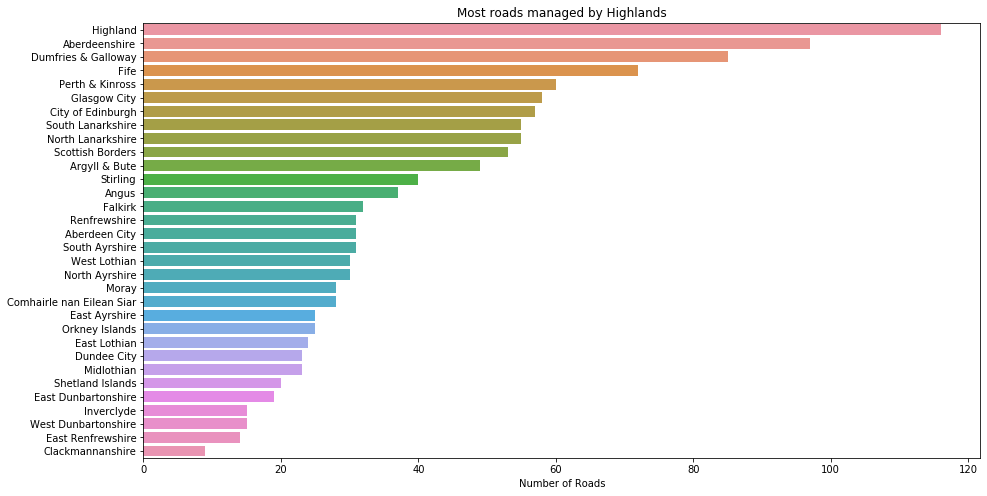

In [31]:
# which local authorities manage the most number of different roads
# drop columns we don't need
data_diff_roads = data.drop(data.columns[range(11, col)], axis = 1)

# get roads where name is U
is_u = data_diff_roads['road_name']=='U'
# data[is_u]
# get roads where name is C
is_c = data_diff_roads['road_name']=='C'

# only have a single row entry per countpoint
data_diff_roads = data_diff_roads.drop_duplicates(subset="count_point_id")

# get dataframe where road names are only U and C
is_u = data_diff_roads['road_name']=='U'
is_c = data_diff_roads['road_name']=='C'
data_u = data_diff_roads[is_u]
data_c = data_diff_roads[is_c]
data_c_u = pd.concat([data_u, data_c])

# get dataframe which only contains road names that aren't U or C
is_u = data_diff_roads['road_name']=='U'
data_no_u = data_diff_roads[-is_u]
is_c_no_uc = data_no_u['road_name']=='C'
data_no_uc = data_no_u[-is_c_no_uc]

# get unique road names 
data_no_uc_unique = data_no_uc.drop_duplicates(subset='road_name')

# combine data no uc and data with ucs
unique_roads = pd.concat([data_c_u, data_no_uc_unique])
# get counts for authorities
authority_counts = unique_roads['local_authority_name'].value_counts()

plt.figure(figsize=(15,8))
ax = sns.barplot(x = authority_counts, y = authority_counts.index)
plt.xlabel('Number of Roads')
plt.title('Most roads managed by Highlands')
plt.show()

The figure above shows that the local authority with the most roads is the Highland area, followed by another area located in the North, Aberdeenshire. Why has one of the least populated areas in Scotland got the highest number of roads? 
Initially, one might think that this is because in the Highlands there might be fewer bigger roads and more
smaller roads compared to other areas of Scotland. To analyse this claim, we next look at the composition 
of major and minor roads within the Top 10 authorities with the most roads. 

# Do the Highlands have the highest percentage of minor roads?

In [32]:
# highlands highest number of minor roads?
# convert series to dataframe 
authority_counts_df = authority_counts.to_frame()

# get top 10
authority_head = authority_counts_df.head(10)
authority_top10 = authority_head.index.to_list() # store top 10 authorities in list
authority_top10_counts = authority_head['local_authority_name'].to_list()
# convert counts list to ndarray
authority_top10_counts = np.asarray(authority_top10_counts)

# filter for top 10 in unique_roads
unique_roads_top10 = unique_roads[unique_roads['local_authority_name'].isin(authority_top10)]
# minor vs major roads
minor_vs_major = unique_roads_top10['road_type'].value_counts() 
# which authority has percentage of most minor roads 
is_minor = unique_roads_top10['road_type']=='Minor'
only_minor_roads = unique_roads_top10[is_minor]
minor_counts_authority = (only_minor_roads['local_authority_name'].value_counts()).to_frame()
# add counts of all roads to dataframe
minor_counts_authority['total_roads'] = authority_top10_counts
minor_counts_authority['minor_perc'] = round(minor_counts_authority['local_authority_name']/minor_counts_authority['total_roads'],2)
minor_counts_authority.sort_values(by=['minor_perc'], ascending= False, inplace=True)
# change name of first columns
minor_counts_authority.rename(columns={'local_authority_name': 'nu_of_minor'})

,nu_of_minor,total_roads,minor_perc
Aberdeenshire,81,97,0.84
Perth & Kinross,48,57,0.84
City of Edinburgh,46,55,0.84
South Lanarkshire,48,58,0.83
Glasgow City,49,60,0.82
North Lanarkshire,44,55,0.80
Dumfries & Galloway,64,85,0.75
Scottish Borders,40,53,0.75
Fife,53,72,0.74
Highland,83,116,0.72


Surprisingly, within the Top 10, the Highlands have the least amount of minor roads to manage. A possible explanation might be that roads of smaller size in the Highlands might still be major roads since they represent important connections between remote towns and villages. 

# Conclusion

All in all, this analysis has shown that most of the traffic in Scotland occurs within the Central Belt. This makes sense geographically, since two major Scottish cities, Glasgow and Edinburgh, are located here. One of the reasons why traffic might be so high in this area is commuting between the cities for work and leisue. 
We have seen further that one of the remotest areas in Scotland, the Highlands, has surprisingly many roads. This could be because despite its remoteness, the Highlands need to be connected to the major cities in Scotland, justifying the need for many roads up North. 
